In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [16]:
import pandas as pd, numpy as np
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import f1_score, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit,StratifiedKFold, RepeatedStratifiedKFold
from pathlib import Path
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
from scipy.sparse import hstack
import warnings
warnings.filterwarnings('ignore')
tqdm().pandas('progress')
from fastai.text import *

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [17]:
def get_score(y_valid_true, valid_pred):
    if hasattr(m, 'oob_score_'): print(f'oob: {m.oob_score_}')
    print(f"f1_score : {f1_score(y_valid_true, valid_pred,average='macro')}")
    print(f"accuracy: {accuracy_score(y_valid_true, valid_pred)}")    

In [18]:
path = Path('data')

In [19]:
train_df = pd.read_csv(path/'train.csv')
test_df = pd.read_csv(path/'test.csv')

In [20]:
train_df.shape, test_df.shape

((5279, 4), (2924, 3))

In [21]:
train_df.drop(['unique_hash'], axis=1,inplace=True)
test_df.drop(['unique_hash'], axis=1,inplace=True)

In [29]:
drug_names = set(list(train_df.drug.unique()) + list(test_df.drug.unique()))

def feature_exists(x):
    return (x['text'].find(x['drug']) != -1)

def feature_other_exists(x):
    drug = x['drug']
    text = x['text']
    return sum([(text.find(d) != -1) for d in drug_names if d not in drug]) > 0

def feature_count(x):
    return x['text'].split().count(x['drug'])

def feature_length(x):
    return len(x['text'].split())

def feature_others(x):
    drug = x['drug']
    text = x['text']
    return sum(text.split().count(d) for d in drug_names if d not in drug)


features = [feature_exists,feature_count,feature_length,
            feature_others,feature_other_exists]

for feature in tqdm(features):
    train_df[feature.__name__] = train_df[['text','drug']].apply(feature,axis=1)
    test_df[feature.__name__] = test_df[['text','drug']].apply(feature,axis=1)

In [ ]:
for df in ([train_df,test_df]):
    df['length'] = df['text'].progress_apply(lambda x : len(x))
    df['capitals'] = df['text'].progress_apply(lambda comment: sum(1 for c in comment if c.isupper()))
    df['caps_vs_length'] = df.progress_apply(lambda row: float(row['capitals'])/float(row['length']),axis=1)
    df['num_exclamation_marks'] = df['text'].progress_apply(lambda comment: comment.count('!'))
    df['num_question_marks'] = df['text'].progress_apply(lambda comment: comment.count('?'))
    df['num_punctuation'] = df['text'].progress_apply(lambda comment: sum(comment.count(w) for w in '.,;:'))
    df['num_symbols'] = df['text'].progress_apply(lambda comment: sum(comment.count(w) for w in '*&$%'))
    df['num_words'] = df['text'].progress_apply(lambda comment: len(comment.split()))
    df['num_unique_words'] = df['text'].progress_apply(lambda comment: len(set(w for w in comment.split())))
    df['words_vs_unique'] = df['num_unique_words'] / df['num_words']

In [31]:
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

def tag_part_of_speech(text):
    text_splited = text.split(' ')
    text_splited = [''.join(c for c in s if c not in string.punctuation) for s in text_splited]
    text_splited = [s for s in text_splited if s]
    pos_list = pos_tag(text_splited)
    noun_count = len([w for w in pos_list if w[1] in ('NN','NNP','NNPS','NNS')])
    adjective_count = len([w for w in pos_list if w[1] in ('JJ','JJR','JJS')])
    verb_count = len([w for w in pos_list if w[1] in ('VB','VBD','VBG','VBN','VBP','VBZ')])
    return[noun_count, adjective_count, verb_count]

In [ ]:
for df in ([train_df,test_df]):
    df['nouns'], df['adjectives'], df['verbs'] = zip(*df['text'].progress_apply(
        lambda comment: tag_part_of_speech(comment)))
    df['nouns_vs_length'] = df['nouns'] / df['length']
    df['adjectives_vs_length'] = df['adjectives'] / df['length']
    df['verbs_vs_length'] = df['verbs'] /df['length']
    df['nouns_vs_words'] = df['nouns'] / df['num_words']
    df['adjectives_vs_words'] = df['adjectives'] / df['num_words']
    df['verbs_vs_words'] = df['verbs'] / df['num_words']
    df["count_words_title"] = df["text"].progress_apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
    df["mean_word_len"] = df["text"].progress_apply(lambda x: np.mean([len(w) for w in str(x).split()]))
    df['punct_percent']= df['num_punctuation']*100/df['num_words']


In [ ]:
le = LabelEncoder()
le.fit(list(train_df['drug'].values) + list(test_df['drug'].values))

train_df['drug'] = le.transform(train_df['drug'])
test_df['drug'] = le.transform(test_df['drug'])

In [33]:
train_df.to_csv('train_processed.csv',index=False)
test_df.to_csv('test_processed.csv',index=False)

See how the data looks

In [12]:
train_df[['nouns','nouns_vs_length','adjectives_vs_length','verbs_vs_length','nouns_vs_words','adjectives_vs_words','verbs_vs_words']].head(8)

,nouns,nouns_vs_length,adjectives_vs_length,verbs_vs_length,nouns_vs_words,adjectives_vs_words,verbs_vs_words
0,22,0.054455,0.014851,0.037129,0.289474,0.078947,0.197368
1,46,0.038851,0.015203,0.033784,0.223301,0.087379,0.194175
2,33,0.042308,0.015385,0.030769,0.246269,0.089552,0.179104
3,5,0.040323,0.024194,0.032258,0.250000,0.150000,0.200000
4,38,0.062092,0.014706,0.027778,0.330435,0.078261,0.147826
5,8,0.028070,0.003509,0.031579,0.216216,0.027027,0.243243
6,33,0.043709,0.007947,0.030464,0.279661,0.050847,0.194915
7,29,0.040111,0.012448,0.048409,0.211679,0.065693,0.255474


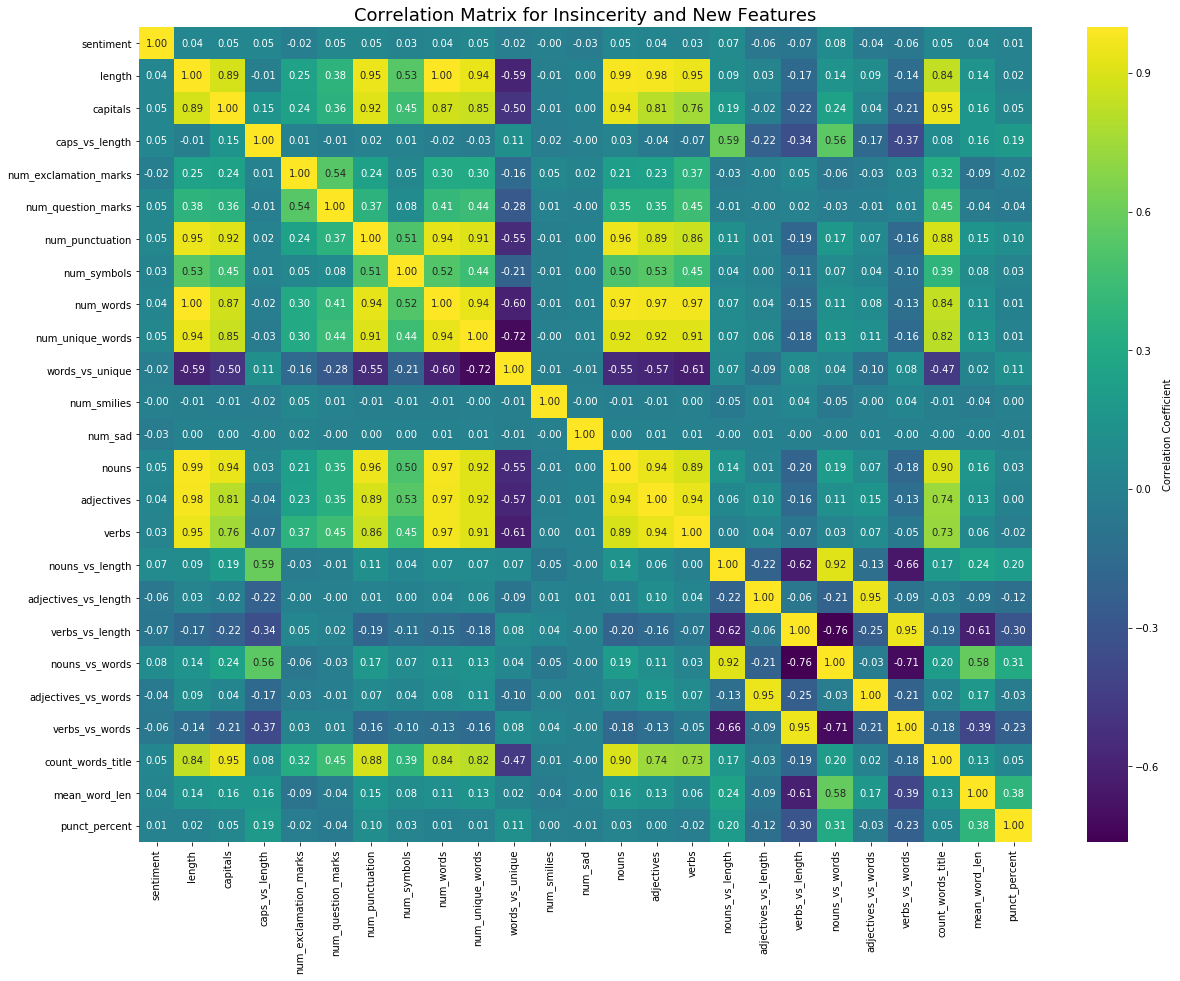

In [34]:
f, ax = plt.subplots(figsize= [20,15])
sns.heatmap(train_df.drop(['text'], axis=1).corr(), annot=True, fmt=".2f", ax=ax, 
            cbar_kws={'label': 'Correlation Coefficient'}, cmap='viridis')
ax.set_title("Correlation Matrix for Insincerity and New Features", fontsize=18)
plt.show()

In [69]:
X_train, X_test, y_train, y_test = train_test_split(train_df.drop(['sentiment','text'],axis=1).as_matrix(),
                                                    train_df.sentiment.as_matrix(),
                                                    random_state=17)

In [74]:
X_train.shape, y_train.shape

((3959, 29), (3959,))

In [94]:
########### RANDOMSEARCHCV ###############

# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.model_selection import KFold, cross_val_score
# from sklearn.metrics import f1_score, make_scorer
# from scipy.stats import randint
# from functools import partial
# random_state=17
# n_iter=50
# num_folds=2
# kf = KFold(n_splits=num_folds, random_state=random_state)
# model = RandomForestClassifier(class_weight='balanced')
# param_grid_rand={'min_samples_leaf': [1,5,7],
#                  'max_depth':  randint(2,20),
#                  'n_estimators': randint(50,2000),
#                  'random_state': [random_state]}
# f1_score = make_scorer(f1_score,average="macro")

# rs = RandomizedSearchCV(model, param_grid_rand, n_iter = n_iter, scoring=f1_score, fit_params=None, 
#                 n_jobs=-1, cv=kf, verbose=False, random_state=random_state)

# rs.fit(X_train, y_train)
# rs.best_estimator_

In [44]:
X_train, X_test, y_train = train_df.drop(['sentiment','text'],axis=1),test_df.drop('text',axis=1),train_df.sentiment.values

In [45]:
X_train.shape,y_train.shape, X_test.shape

((5279, 28), (5279,), (2924, 28))

In [58]:
m = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=7, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=7,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=216, n_jobs=None, oob_score=False,
            random_state=17, verbose=0, warm_start=False)
m.fit(X_train,y_train)
predictions = m.predict(X_test)

In [59]:
pred = m.predict_proba(X_test)
np.save('pred_meta',pred)

In [48]:
Counter(preds)

Counter({1: 957, 2: 1484, 0: 483})

In [53]:
I = 16
path_sub =Path('Submissions')
sample = pd.read_csv(path/'sample_submission.csv')
sample['sentiment'] = predictions
sample.to_csv(path_sub/f'submission{I}.csv',index=False)